Based on ds_tree.ipynb

This is the data structure based on the theory section of the thesis, which tries to be as minimal as possible.
We then have:
- constructor functions that can build this data structure. E.g:
    - random networks
    - sympy equation builder
    - manual solver structure builder
- mapping functions that can associate additional information with each datastructure. E.g:
    - openMDAO namer(or any other renamer)
    - mapping to actualy functions(that need to have the correct data shape for input and output)
- processing functions that extract useful information based on the datastructures. E.g:
    - returning all variables
    - get input variables
    - get output variables

# Example data structure
## Directed Graph

In [1]:
from graph.graphutils import all_variables, sources

In [2]:
Ein = {
    1: (7,),
    2: (3,6),
    3: (1,),
    4: (2,4),
    5: (3,2)
}
# IMPORTANT: Need to enforce that each output variable 
# can only be connected to one function
Eout = {
    1: (6,),
    2: (1,),
    3: (2,), 
    4: (None,), # this gives us the size of the outputs
    5: (5,), # Use None to indicate the size of the output
}

Rin = {
    #3: (2,) # in original model its 3: (2,), so we have x_2 = f3(x_1)
}

In [3]:
all_variables(Ein, Eout)

{1, 2, 3, 4, 5, 6, 7}

In [4]:
sources(Ein, Eout)

{3, 4, 7}

# Typed graph

In [14]:
from graph.graphutils import all_edges, merge_edges, Node, transform_E, COMP, VAR
from graph.graphview import draw
from functools import partial
import networkx as nx

## Flat graph
This is the flat graph that doesn't use any information about the tree

In [10]:
edges = all_edges(merge_edges(Ein,Rin), Eout, partial(transform_E, tfx=lambda x: Node(x, COMP), tvar=lambda x: Node(x, VAR)))

In [11]:
G = nx.DiGraph(edges)

In [12]:
var_names = [Node(var, VAR) for var in all_variables(Ein, Eout)]

c:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Error: remove_overlap: Graphviz not built with triangulation library

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


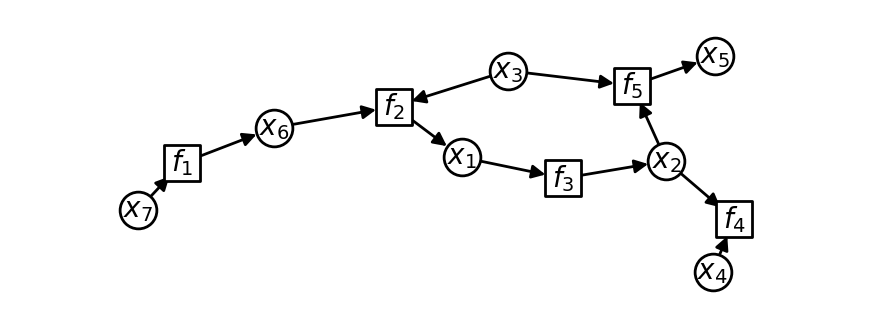

In [15]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape=node_shapes, prog='sfdp', figsize=(11,4), latexlabels=False);

## Ordered tree

In [16]:
from collections import OrderedDict

In [17]:
Stree = {
    2:1
}
Ftree = OrderedDict((
    (1,1),
    (2,2),
    (3,2),
    (4,2),
    (5,1)
))
Vtree = {
    3:2
}

## Functions

In [18]:
Ein = {
    1: (7,),
    2: (3,6),
    3: (1,),
    4: (2,4),
    5: (3,2)
}
# IMPORTANT: Need to enforce that each output variable 
# can only be connected to one function
Eout = {
    1: (6,),
    2: (1,),
    3: (2,), 
    4: (None,), # this gives us the size of the outputs
    5: (5,), # Use None to indicate the size of the output
}

Rin = {
    #3: (2,) # in original model its 3: (2,), so we have x_2 = f3(x_1)
}

In [19]:
# lookup table for functions
f = {
    ((6,),(7,)): lambda x,y: (x+y,),
    ((1,),(3,6)): lambda x,y,z: (x+y+z,),
    ((2,),(1,)): lambda x: x**2,
    ((None,),(2,4)): lambda x,y: (x+y,),
    ((5,),(3,2)): lambda x,y,z: (x+y,)
}

# Generating workflows

## Merging

In [21]:
from graph.mergegraph import get_edges,merge_graph
merge_comps = {2,3,4}

Need to operate on graphs

In [23]:
G_parent, G_child = merge_graph(G, {Node(2,COMP),Node(3,COMP)}, {Node(3, VAR)}, solver_idx=1)

In [25]:
G_parent2, G_child2 = merge_graph(G_parent, {Node(4,COMP),Node(5,COMP), Node(1,COMP)}, set(), solver_idx=2)

c:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Error: remove_overlap: Graphviz not built with triangulation library

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


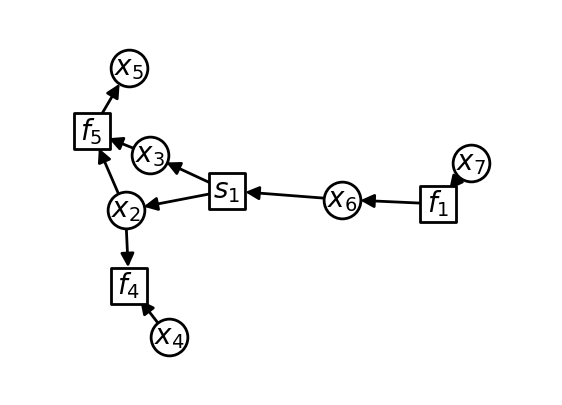

In [26]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G_parent.nodes()}
draw(G_parent, node_shape=node_shapes, prog='sfdp',figsize=(7,5), latexlabels=False);

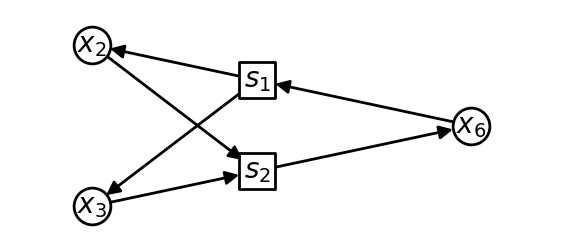

In [27]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G_parent2.nodes()}
draw(G_parent2, node_shape=node_shapes, prog='sfdp',figsize=(7,3), latexlabels=False);

# Build graphs

In [31]:
from graph.nestedgraph import level_order_tree, build_typedgraph

In [29]:
tree = {
    2:1,
}

In [30]:
level_order_tree(tree)

[1, 2]

In [35]:
graphs = build_typedgraph((Ein, Eout, Rin), (Ftree, Stree, Vtree))

c:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Error: remove_overlap: Graphviz not built with triangulation library

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


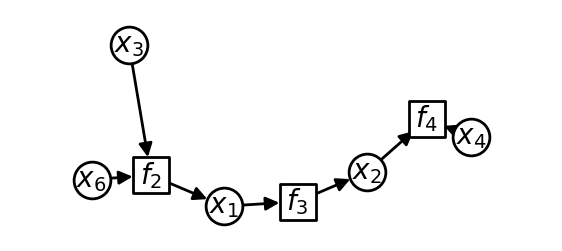

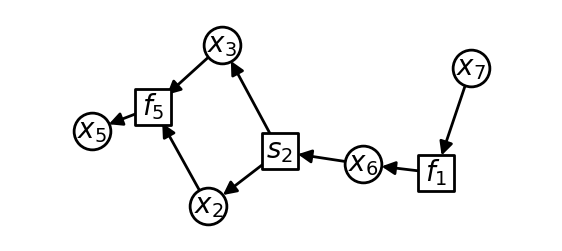

In [36]:
for key,graph in graphs.items():
    node_shapes = {elt:'o' if elt in var_names else 's' for elt in graph.nodes()}
    draw(graph, node_shape=node_shapes, prog='sfdp',figsize=(7,3), latexlabels=False);

# Operations

In [43]:
from graph.operators import standardize_comp, standardize_solver

In [38]:
Ein = {
    1: (2,),
    2: (1,),
}
Eout = {
    1: (1,),
    2: (2,)
}
Rin = {
}
Vtree=dict()
Ftree=OrderedDict(((1,1),(2,1)))

In [39]:
edges = (Ein, Eout, Rin)
tree = (Vtree, Ftree)
edges, Vtree = standardize_comp(edges, Vtree, Ftree, 1)
edges, Vtree = standardize_comp(edges, Vtree, Ftree, 2)

In [40]:
stEin = merge_edges(edges[0], edges[2])
stEout = edges[1]
Gedges = all_edges(Ein, Eout, partial(transform_E, tfx=lambda x: Node(x, COMP), tvar=lambda x: Node(x, VAR)))

In [41]:
G = nx.DiGraph(Gedges)

c:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Error: remove_overlap: Graphviz not built with triangulation library

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


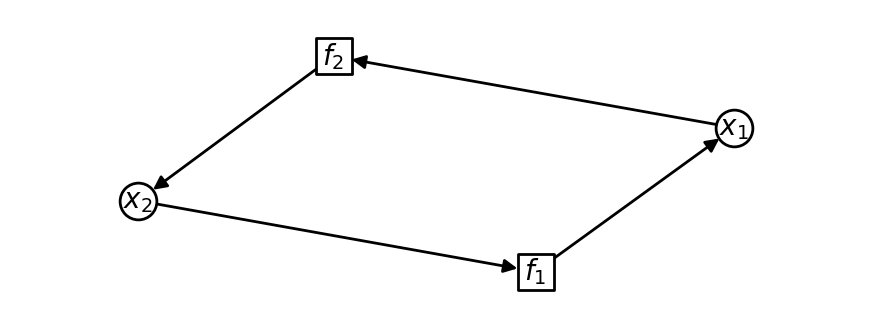

In [42]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape=node_shapes, prog='sfdp', figsize=(11,4), latexlabels=False);

For solver we should just unmerge it (assumed that it is acyclic)

In [44]:
Ein = {
    1: (1,2),
    2: (2,1,3),
    3: (2,),
}
Eout = {
    1: (None,),
    2: (None,),
    3: (3,)
}
Rin = {
}
Vtree=dict()
Ftree=OrderedDict(((1,2),(2,2),(3,1)))
Stree={2:1}

In [45]:
standardize_solver((Ftree, Stree), 2)

({1: 1, 2: 1, 3: 1}, {})

# Make acyclic

This operates on the DiGraph with class nodes structure

In [46]:
from graph.operators import sort_scc

In [47]:
newStree = dict(Stree)
newFtree = OrderedDict()
newVtree = dict(Vtree)

In [48]:
Ein = {
    1: (2,),
    2: (1,),
    3: (2,3),
}
Eout = {
    1: (1,),
    2: (2,),
    3: (None,)
}
Rin = {
}
Vtree={3:1}
Ftree=OrderedDict(((1,1),(2,1),(3,1)))
Stree=dict()

In [49]:
Gedges = all_edges(merge_edges(Ein, Rin), Eout, partial(transform_E, tfx=lambda x: Node(x, COMP), tvar=lambda x: Node(x, VAR)))
G = nx.DiGraph(Gedges)

c:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Error: remove_overlap: Graphviz not built with triangulation library

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


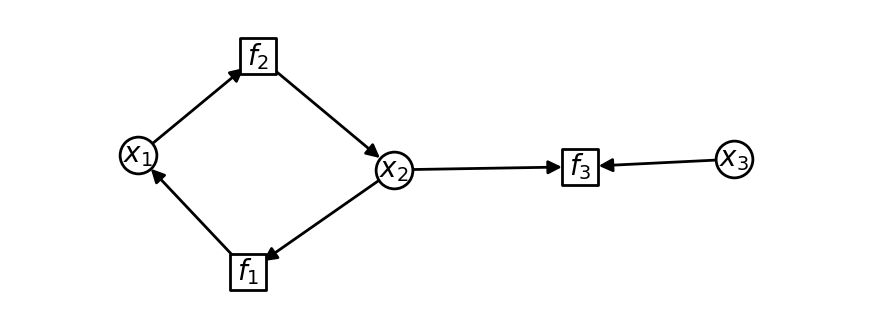

In [50]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape=node_shapes, prog='sfdp', figsize=(11,4), latexlabels=False);

In [438]:
edges = Ein, Eout, Rin
tree = Ftree,Stree,Vtree

In [439]:
def merge_and_standardize(edges, tree, mergecomps, parentidx=1, newidx=2):
    Ftree, Stree, Vtree = tree
    Ftree = OrderedDict(Ftree)
    Stree = dict(Stree)
    Stree[newidx]=parentidx
    for node in mergecomps:
        if node.nodetype == COMP:
            assert Ftree[node.name] == parentidx # can only merge nodes at the same level
            Ftree[node.name] = newidx
            edges, Vtree = standardize_comp(edges, Vtree, Ftree, 
                                            node.name, vrs=None)
        else:
            assert Stree[node.name] == parentidx
            # we remove the solver and raise all children one level up
            Ftree, Stree = standardize_solver(Ftree, Stree, node.name)
    return edges, (Ftree, Stree, Vtree)

In [440]:
edges, tree

(({1: (2,), 2: (1,), 3: (2, 3)}, {1: (1,), 2: (2,), 3: (None,)}, {}),
 (OrderedDict([(1, 1), (2, 1), (3, 1)]), {}, {3: 1}))

In [441]:
nedges, ntree = merge_and_standardize(edges, tree, {Node(1,COMP),Node(2,COMP)}, 1, 2)

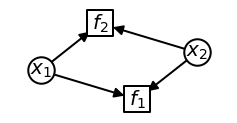

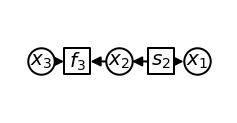

In [442]:
Gedges = all_edges(merge_edges(nedges[0], nedges[2]), nedges[1], partial(transform_E, tfx=lambda x: Node(x, COMP), tvar=lambda x: Node(x, VAR)))
G = nx.DiGraph(Gedges)
graphs = build_typedgraph(G, *ntree)
for key,graph in graphs.items():
    node_shapes = {elt:'o' if elt in var_names else 's' for elt in graph.nodes()}
    draw(graph, node_shape=node_shapes, prog='sfdp',figsize=(4,2), latexlabels=False);

In [443]:
scc = [{Node(1,COMP),Node(2,COMP)},{Node(3,COMP)}]

In [444]:
def reorder_merge_solve(edges, tree, merge_order, solver_idx, mdf=True):
    tree = tuple((dict(d) if idx !=0 else OrderedDict(d)) for idx, d in enumerate(tree))
    nFtree = OrderedDict()
    for connected_components in scc:
        if len(connected_components) > 1:
            new_idx = max(chain(Stree.keys(),(1,)))+1
            edges, tree = merge_and_standardize(edges, tree, connected_components, solver_idx, new_idx)
        Ftree = tree[0]
        for node in connected_components:
                if node.nodetype == COMP:
                    nFtree[node.name] = Ftree[node.name]
    return edges, (nFtree, ntree[1], ntree[2])

In [445]:
edges, tree

(({1: (2,), 2: (1,), 3: (2, 3)}, {1: (1,), 2: (2,), 3: (None,)}, {}),
 (OrderedDict([(1, 1), (2, 1), (3, 1)]), {}, {3: 1}))

In [446]:
nedges, ntree = reorder_merge_solve(edges, tree, scc, solver_idx)

In [447]:
nedges, ntree

(({1: (2,), 2: (1,), 3: (2, 3)},
  {1: (None,), 2: (None,), 3: (None,)},
  {2: (2,), 1: (1,)}),
 (OrderedDict([(2, 2), (1, 2), (3, 1)]), {2: 1}, {3: 1, 2: 2, 1: 2}))

In [448]:
ntree[0].keys()

odict_keys([2, 1, 3])

In [449]:
stEin = merge_edges(nedges[0], nedges[2])
stEout = nedges[1]
Gedges = all_edges(stEin, stEout, partial(transform_E, tfx=lambda x: Node(x, COMP), tvar=lambda x: Node(x, VAR)))

In [450]:
G = nx.DiGraph(Gedges)

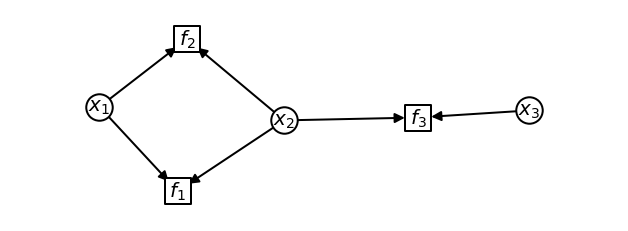

In [451]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape=node_shapes, prog='sfdp', figsize=(11,4), latexlabels=False);

# Workflow generation based on tree

In [452]:
Vtree=dict()
Ftree=OrderedDict(((1,2),(2,2),(3,1)))
Stree={2:1, 3:2, 4:3}

In [453]:
def path(Stree, s, visited=None):
    visited = visited if visited else set()
    out = []
    q = {s} if s in chain(Stree.values(),Stree.keys()) else set()
    while q:
        s = q.pop()
        if s not in visited:
            out.append(s)
            if s in Stree:
                q.add(Stree[s])
        visited.add(s)
    return out

In [454]:
path(Stree, 4, visited={3})

[4]

In [455]:
nedges

({1: (2,), 2: (1,), 3: (2, 3)},
 {1: (None,), 2: (None,), 3: (None,)},
 {2: (2,), 1: (1,)})

In [456]:
Fend = end_components(nedges[1])

In [457]:
def generate_workflow(Ftree, Stree, Vtree):
    visited = set()
    workflow = []
    for key,parentsolver in Ftree.items():
        out = path(Stree, parentsolver, visited)
        visited = visited.union(out) 
        workflow.extend([("solver", s, Stree.get(s, None), solver_children(Vtree, s), solver_children({F:Ftree[F] for F in Fend}, s)) for s in out[::-1]])
        workflow.append(("exec", key, parentsolver))
    return workflow

In [458]:
generate_workflow(*ntree)

[('solver', 1, None, {3}, {3}),
 ('solver', 2, 1, {1, 2}, {1, 2}),
 ('exec', 2, 2),
 ('exec', 1, 2),
 ('exec', 3, 1)]

# Simplifications

Solver simplification and residual simplification can be merged under one idea

This allows to override the solver creation, and instead replace the execs that would fall underneath with one function

In [22]:
# The idea is that it replaces any solvers it sees with the following inputs and outputs with a new exec with the following function:
sargmap = {
    ((2,3),(1,2)): lambda x,y: (x+y,x*y), #for a solver for example
    ((1,2),(None,)): lambda x,y: y-f[((1,),(2,))](x) # for a residualized example, for elements in Rin
}

In [25]:
sargmap[((1,2),(None,))](5,4)

-21

## Automatic generation of residual functions
Should also work with multivariable residuals

In [199]:
Ein = {
    1: (2,),
    2: (1,),
}
Eout = {
    1: (None,),
    2: (None,),
}
Rin = {
    1: (1,),
    2: (2,),
}

In [137]:
f = {
    ((1,),(2,)): lambda x: x**2,
    ((2,),(1,)): lambda x: x+200
}

In [192]:
def bindFunction(function, n_reversed):
    def residual(*x):
        return np.array(x[n_reversed:])-function(*x[0:n_reversed]) 
    return residual

In [193]:
def generate_residuals(Ein, Rin, f):
    residuals = dict()
    merged_edges = merge_edges(Ein,Rin) # this makes sure we get the same order as used during workflow generation
    for fx,ins in Rin.items():
        merged_ins = merged_edges[fx]
        fkey = (Rin[fx], Ein[fx]) #Rin encodes the old outputs
        function = f[fkey]
        n_reversed = len(ins)
        output_size = (None,)*n_reversed
        # need to do some local binding for residual function
        residuals[(merged_ins, output_size)] = bindFunction(function, n_reversed)
    return residuals

In [194]:
residuals = generate_residuals(Ein, Rin, f)

In [200]:
residuals

{((1, 2), (None,)): <function __main__.bindFunction.<locals>.residual(*x)>,
 ((2, 1), (None,)): <function __main__.bindFunction.<locals>.residual(*x)>}

In [196]:
residuals[((2, 1), (None,))](10,1)

array([-99])

In [197]:
residuals[((1, 2), (None,))](10,1)

array([-209])

# Random problem demo

In [50]:
from testproblems import generate_random_prob

In [57]:
n_eqs = 4
n_vars = 8
seed = 42#8 is triang#seed 10 is nice
sparsity = .8#1.1 #1.7
eqv, varinc, dout = generate_random_prob(n_eqs, n_vars, seed, sparsity)
Ein = {key: tuple(vr-n_eqs for vr in var if vr !=dout[key]) for key,var in eqv.items()}
Eout = {key: (var-n_eqs,) for key,var in dout.items()}
Rin = dict()
Ftree=OrderedDict((idx,1) for idx in range(n_eqs))
Stree=dict()
Vtree=dict()

In [58]:
Ein

{0: (2, 3, 4, 5), 1: (1, 5), 2: (4, 5, 7), 3: (0, 1, 4, 5)}

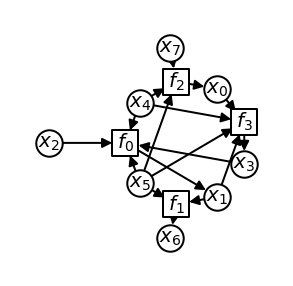

In [59]:
edges = all_edges(merge_edges(Ein,Rin), Eout, partial(transform_E, tfx=lambda x: Node(x, COMP), tvar=lambda x: Node(x, VAR)))
G = nx.DiGraph(edges)
var_names = [Node(var, VAR) for var in all_variables(Ein, Eout)]
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape=node_shapes, prog='circo', figsize=(5,5), latexlabels=False);